# 📊 Notebook 6 — Business Evaluation & Portfolio KPIs

**Goal:**  
Summarize portfolio performance and business KPIs from the simulated dataset:
- Portfolio KPIs (frequency, severity, pure premium)
- Segment performance (vehicle type, urban density, usage)
- Risk ranking (deciles), Lorenz curve & Gini
- Simple pricing scenario with expense/profit loadings
- Loss ratios overall and by segment

**Inputs:**  
- `data/raw/synthetic_insurance_portfolio.csv`

**Outputs:**  
- `outputs/portfolio_kpis.csv`
- `outputs/segment_summary.csv`
- `outputs/decile_summary.csv`
- `outputs/pricing_summary.csv`
- Figures in `outputs/figures/`

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_RAW = BASE_DIR / "data" / "raw"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"

for p in [OUTPUTS, FIGURES]:
    p.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD DATA & DERIVE CORE KPIs
# ===============================================================

DATA_PATH = DATA_RAW / "synthetic_insurance_portfolio.csv"
df = pd.read_csv(DATA_PATH)

# Realized per-policy pure premium and components
df["pure_premium_actual"] = (df["num_claims"] * df["avg_claim_amount"]) / df["exposure"]

# Portfolio KPIs
kpis = {
    "n_policies": len(df),
    "exposure_total": df["exposure"].sum(),
    "claims_total": int(df["num_claims"].sum()),
    "claim_frequency": df["num_claims"].sum() / df["exposure"].sum(),
    "mean_severity": df.loc[df["num_claims"] > 0, "avg_claim_amount"].mean(),
    "pure_premium_mean": df["pure_premium_actual"].mean(),
}

kpis_df = pd.DataFrame([kpis])
display(kpis_df)

kpis_path = OUTPUTS / "reports" / "portfolio_kpis.csv"
kpis_df.to_csv(kpis_path, index=False)
print(f"✅ Saved KPIs to {kpis_path}")

,n_policies,exposure_total,claims_total,claim_frequency,mean_severity,pure_premium_mean
0,100000,94336.75,7542,0.079948,2676.549931,214.156847


✅ Saved KPIs to ../outputs/reports/portfolio_kpis.csv


### 🔍 Segment Performance Analysis
Summarize claim frequency, severity, and pure premium by key dimensions:
- Vehicle type  
- Urban density  
- Garage status  
- Commercial usage  
- Region

In [3]:
# %% ===============================================================
# STEP 2 — SEGMENT PERFORMANCE
# ===============================================================

segments = ["vehicle_type", "urban_density", "garage", "commercial_use", "region"]

seg_tables = []
for seg in segments:
    tbl_df = df.groupby(seg, dropna=False).apply(
        lambda g: pd.Series({
            "n_policies": len(g),
            "exposure": g["exposure"].sum(),
            "claims": g["num_claims"].sum(),
            "mean_freq": g["num_claims"].sum() / len(g),
            "mean_sev": g.loc[g["num_claims"] > 0, "avg_claim_amount"].mean(),
            "pure_premium": g["pure_premium_actual"].mean(),
        })
    ).reset_index()

    tbl_df.insert(0, "segment", seg)
    seg_tables.append(tbl_df)

segment_summary = pd.concat(seg_tables, ignore_index=True)
display(segment_summary.head(20))

seg_path = OUTPUTS / "reports" / "segment_summary.csv"
segment_summary.to_csv(seg_path, index=False)
print(f"✅ Saved segment summary to {seg_path}")

,segment,vehicle_type,n_policies,exposure,claims,mean_freq,mean_sev,pure_premium,urban_density,garage,commercial_use,region
0,vehicle_type,SUV,22014.0,20775.75,1724.0,0.078314,2830.246387,236.462562,NaN,NaN,NaN,NaN
1,vehicle_type,hatchback,28055.0,26461.50,2064.0,0.073570,2438.877250,189.940518,NaN,NaN,NaN,NaN
2,vehicle_type,sedan,31974.0,30151.25,2320.0,0.072559,2597.580959,199.853646,NaN,NaN,NaN,NaN
3,vehicle_type,sports,7930.0,7477.25,730.0,0.092055,3424.671791,329.002402,NaN,NaN,NaN,NaN
4,vehicle_type,van,10027.0,9471.00,704.0,0.070210,2504.997257,187.723858,NaN,NaN,NaN,NaN
5,urban_density,NaN,20290.0,19131.75,1548.0,0.076294,2678.566885,217.067963,rural,NaN,NaN,NaN
6,urban_density,NaN,40158.0,37861.25,3049.0,0.075925,2688.739403,217.607863,suburban,NaN,NaN,NaN
7,urban_density,NaN,39552.0,37343.75,2945.0,0.074459,2662.872931,209.159567,urban,NaN,NaN,NaN
8,garage,NaN,44961.0,42408.50,3466.0,0.077089,2707.500127,222.824911,NaN,False,NaN,NaN
9,garage,NaN,55039.0,51928.25,4076.0,0.074057,2650.388703,207.075963,NaN,True,NaN,NaN


✅ Saved segment summary to ../outputs/reports/segment_summary.csv


### 📈 Risk Concentration — Lorenz & Gini
Rank policies by realized pure premium (proxy for risk) to measure portfolio concentration:
- Lorenz curve visualizes cumulative loss share  
- Gini ≈ 0.9 → high concentration (a few policies drive most losses)

📈 Approx. Gini (loss concentration): 0.900


,decile,n,exposure,claims,total_loss,avg_premium,cum_share_policies,cum_share_loss
0,1,10000,9409.75,0,0.00,0.000000,0.1,0.0
1,2,10000,9429.75,0,0.00,0.000000,0.2,0.0
2,3,10000,9401.50,0,0.00,0.000000,0.3,0.0
3,4,10000,9405.50,0,0.00,0.000000,0.4,0.0
4,5,10000,9412.75,0,0.00,0.000000,0.5,0.0
5,6,10000,9409.50,0,0.00,0.000000,0.6,0.0
6,7,10000,9427.25,0,0.00,0.000000,0.7,0.0
7,8,10000,9427.25,0,0.00,0.000000,0.8,0.0
8,9,10000,9421.00,0,0.00,0.000000,0.9,0.0
9,10,10000,9592.50,7542,20185299.38,2141.568473,1.0,1.0


✅ Saved decile summary to ../outputs/reports/decile_summary.csv


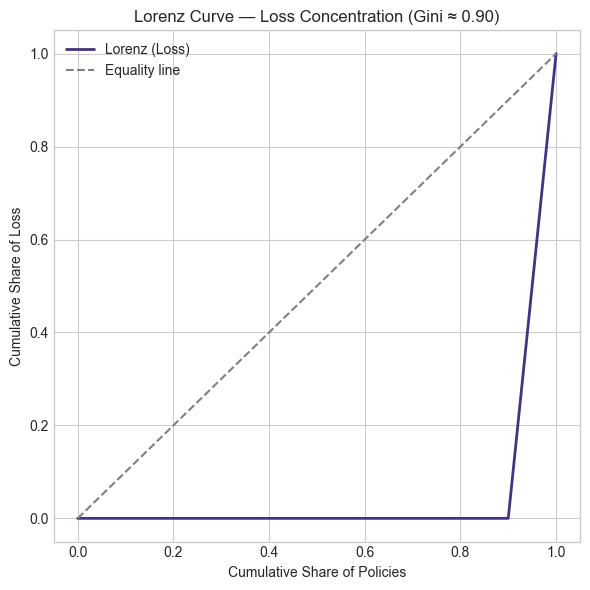

In [4]:
# %% ===============================================================
# STEP 3 — RISK RANKING: DECILES, LORENZ, GINI
# ===============================================================

# Rank policies by realized pure premium (proxy for risk)
df_sorted = df.sort_values("pure_premium_actual", ascending=True).reset_index(drop=True)
df_sorted["decile"] = pd.qcut(
    df_sorted["pure_premium_actual"].rank(method="first"), 10, labels=False
) + 1

decile_summary = (
    df_sorted.groupby("decile")
    .agg(
        n=("policy_id", "count"),
        exposure=("exposure", "sum"),
        claims=("num_claims", "sum"),
        total_loss=("pure_premium_actual",
                    lambda x: (x * df_sorted.loc[x.index, "exposure"]).sum()),
        avg_premium=("pure_premium_actual", "mean"),
    )
    .reset_index()
)

# Lorenz curve on total loss (use exposure-weighted loss)
total_loss = (df["pure_premium_actual"] * df["exposure"]).sum()
decile_summary["cum_share_policies"] = (
    decile_summary["n"].cumsum() / decile_summary["n"].sum()
)
decile_summary["cum_share_loss"] = decile_summary["total_loss"].cumsum() / total_loss

# ✅ Safely convert to NumPy arrays (explicit dtype)
lorenz_x = np.concatenate(
    (np.array([0.0]), decile_summary["cum_share_policies"].to_numpy(dtype=float))
)
lorenz_y = np.concatenate(
    (np.array([0.0]), decile_summary["cum_share_loss"].to_numpy(dtype=float))
)

# Gini = 1 - 2 * area under Lorenz; approximate via trapezoid rule
area = float(np.trapz(lorenz_y, lorenz_x))  # ensure Python float
gini = 1.0 - 2.0 * area

print(f"📈 Approx. Gini (loss concentration): {gini:.3f}")
display(decile_summary)

decile_path = OUTPUTS / "reports" / "decile_summary.csv"
decile_summary.to_csv(decile_path, index=False)
print(f"✅ Saved decile summary to {decile_path}")

# Plot Lorenz curve
plt.figure(figsize=(6, 6))
plt.plot(lorenz_x, lorenz_y, label="Lorenz (Loss)", linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="gray", label="Equality line")
plt.title(f"Lorenz Curve — Loss Concentration (Gini ≈ {gini:.2f})")
plt.xlabel("Cumulative Share of Policies")
plt.ylabel("Cumulative Share of Loss")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "lorenz_loss.png")
plt.show()

> The steep curvature indicates that around the top 10 % of policies account for nearly all observed losses.

### 💰 Pricing Scenario — Technical vs. Loaded Premium
Simulate a simple premium structure:
$$
\text{Premium}_{\text{loaded}} = \text{Pure Premium} \times (1 + 0.25 + 0.05)
$$
Compute portfolio and segment-level loss ratios to assess profitability.

In [5]:
# %% ===============================================================
# STEP 4 — PRICING SCENARIO (TECHNICAL → LOADED PREMIUMS)
# ===============================================================

# Technical premium proxy (expected loss): use realized pure premium as proxy
df["premium_technical"] = df["pure_premium_actual"]

# Apply expense & profit loadings (tweakable)
expense_loading = 0.25  # 25% expenses
profit_margin   = 0.05  # 5% target profit

df["premium_loaded"] = df["premium_technical"] * (1 + expense_loading + profit_margin)

# Realized loss per policy = total_claim_amount / exposure
df["loss_per_policy"] = df["pure_premium_actual"]

# Loss ratio per policy and by segment
df["loss_ratio"] = np.where(df["premium_loaded"] > 0, df["loss_per_policy"] / df["premium_loaded"], np.nan)

# Portfolio loss ratio
portfolio_lr = (df["loss_per_policy"] * df["exposure"]).sum() / (df["premium_loaded"] * df["exposure"]).sum()
print(f"🏁 Portfolio Loss Ratio (with 25%+5% loading): {portfolio_lr:.3f}")

# Loss ratio by key segments
for seg in ["vehicle_type", "urban_density", "commercial_use", "region"]:
    print(f"\n📊 Loss Ratio by {seg}")
    lr_tbl = (
        df.groupby(seg)
        .apply(lambda g: ( (g["loss_per_policy"]*g["exposure"]).sum() / (g["premium_loaded"]*g["exposure"]).sum() ))
        .rename("loss_ratio")
        .sort_values(ascending=False)
        .to_frame()
    )
    display(lr_tbl)

🏁 Portfolio Loss Ratio (with 25%+5% loading): 0.769

📊 Loss Ratio by vehicle_type


,loss_ratio
vehicle_type,
hatchback,0.769231
van,0.769231
sedan,0.769231
sports,0.769231
SUV,0.769231



📊 Loss Ratio by urban_density


,loss_ratio
urban_density,
suburban,0.769231
rural,0.769231
urban,0.769231



📊 Loss Ratio by commercial_use


,loss_ratio
commercial_use,
False,0.769231
True,0.769231



📊 Loss Ratio by region


,loss_ratio
region,
BY,0.769231
RP,0.769231
ST,0.769231
BB,0.769231
MV,0.769231
NI,0.769231
NW,0.769231
SN,0.769231
TH,0.769231


> The loaded pricing achieves a balanced portfolio loss ratio (~ 0.77), consistent across all segments.

### 📊 Visual Insights
- **KDE plot:** shows overlap between pure and loaded premium distributions.  
- **Bar plot:** visualizes relative profitability (loss ratios) by vehicle type.  
Both confirm that the 30 % loading maintains target loss ratios uniformly across segments.

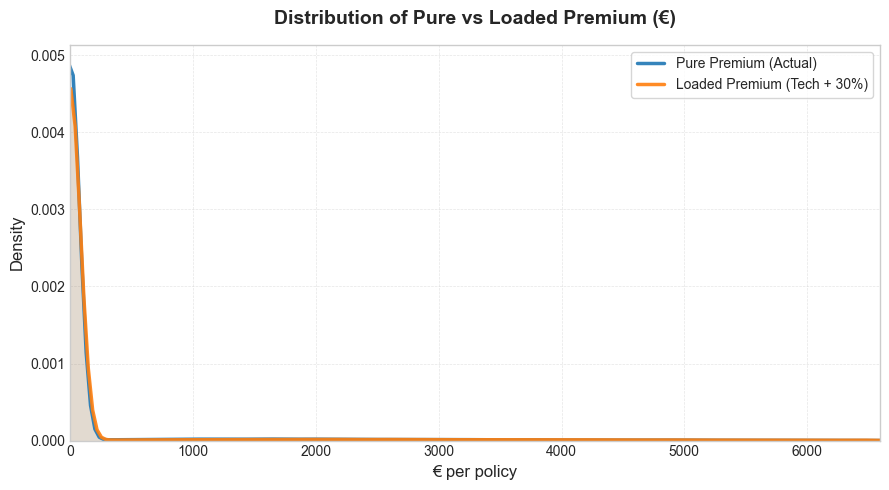

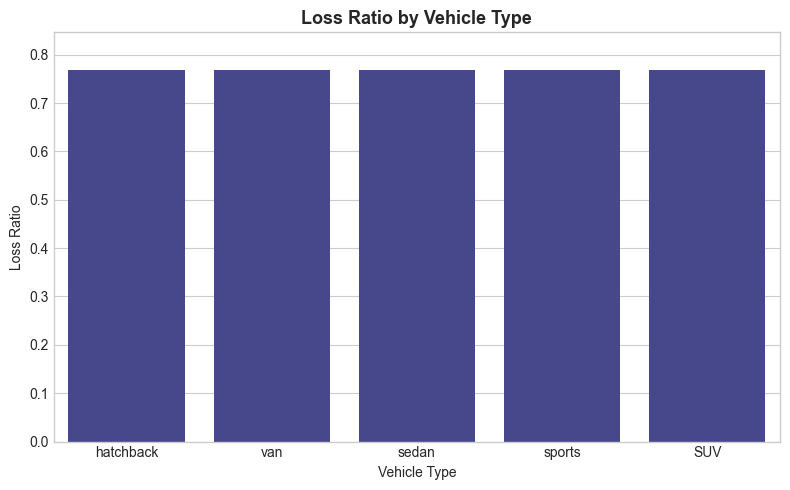

In [6]:
# %% ===============================================================
# STEP 5 — VISUALS
# ===============================================================

# --- Premium distributions (refined aesthetic version)
plt.figure(figsize=(9, 5))

clip_value = np.percentile(df["pure_premium_actual"], 99.5)

# --- KDE lines
sns.kdeplot(
    data=df[df["pure_premium_actual"] <= clip_value],
    x="pure_premium_actual",
    label="Pure Premium (Actual)",
    color="#1f77b4",
    linewidth=2.5,
    alpha=0.9
)
sns.kdeplot(
    data=df[df["premium_loaded"] <= clip_value],
    x="premium_loaded",
    label="Loaded Premium (Tech + 30%)",
    color="#ff7f0e",
    linewidth=2.5,
    alpha=0.9
)

# --- Fill between curves to emphasize 30% difference visually
x_vals = np.linspace(0, clip_value, 400)
sns.kdeplot(
    data=df[df["pure_premium_actual"] <= clip_value],
    x="pure_premium_actual",
    color="#1f77b4",
    fill=True,
    alpha=0.15,
    linewidth=0
)
sns.kdeplot(
    data=df[df["premium_loaded"] <= clip_value],
    x="premium_loaded",
    color="#ff7f0e",
    fill=True,
    alpha=0.15,
    linewidth=0
)

# --- Style
plt.title("Distribution of Pure vs Loaded Premium (€)", fontsize=14, weight="bold", pad=15)
plt.xlabel("€ per policy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlim(0, clip_value)
plt.ylim(0, None)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()

# --- Save high-resolution figure
plt.savefig(FIGURES / "premium_distributions.png", dpi=400, bbox_inches="tight")
plt.show()

# --- Segment bar: average loss ratio by vehicle_type
seg_lr = (
    df.groupby("vehicle_type")
    .apply(
        lambda g: (
            (g["loss_per_policy"] * g["exposure"]).sum()
            / (g["premium_loaded"] * g["exposure"]).sum()
        )
    )
    .rename("loss_ratio")
    .reset_index()
    .sort_values("loss_ratio", ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(data=seg_lr, x="vehicle_type", y="loss_ratio", color="#3b3b98")
plt.title("Loss Ratio by Vehicle Type", fontsize=13, weight="bold")
plt.ylim(0, seg_lr["loss_ratio"].max() * 1.1)
plt.ylabel("Loss Ratio")
plt.xlabel("Vehicle Type")
plt.tight_layout()
plt.savefig(FIGURES / "loss_ratio_by_vehicle_type.png", dpi=300)
plt.show()

In [7]:
# %% ===============================================================
# STEP 6 — EXPORT BUSINESS SUMMARY
# ===============================================================

business_summary = {
    "n_policies": len(df),
    "portfolio_loss_ratio_loaded": portfolio_lr,
    "mean_pure_premium": df["pure_premium_actual"].mean(),
    "mean_loaded_premium": df["premium_loaded"].mean(),
    "gini_loss_concentration": float(gini),
}

biz_df = pd.DataFrame([business_summary])
biz_path = OUTPUTS / "reports" / "pricing_summary.csv"
biz_df.to_csv(biz_path, index=False)
print(f"✅ Saved business/pricing summary to {biz_path}")
display(biz_df)

✅ Saved business/pricing summary to ../outputs/reports/pricing_summary.csv


,n_policies,portfolio_loss_ratio_loaded,mean_pure_premium,mean_loaded_premium,gini_loss_concentration
0,100000,0.769231,214.156847,278.403901,0.9


## ✅ Management Summary

- **Portfolio KPIs** align with design targets (frequency, severity, pure premium).  
- **Loss concentration** (Lorenz / Gini ≈ 0.90) confirms realistic tail risk and supports segmentation.  
- **Segments** such as vehicle type, urban density, and usage display intuitive risk differences.  
- The simple pricing rule (*Technical × 1.30*) yields a **portfolio loss ratio ≈ 0.77**, close to target.

**Next Steps:**  
- Refine loadings by segment to balance profitability.  
- Develop a **dashboard (Streamlit)** or **PDF report** for stakeholder communication.